# 🌍 Küresel Readiness Eşitsizliklerini Sayılarla Görünür Kılmak
## 🎯 Projenin Amacı

İklim krizi tüm dünyayı etkiliyor ama herkesi aynı şekilde değil. En az sorumluluğu taşıyan ülkeler, çoğu zaman bu krizin en ağır bedellerini ödüyor. Düşük gelirli ve yapısal olarak kırılgan toplumlar; afetler, kuraklık ve sıcaklık artışları gibi iklimsel risklere karşı daha savunmasız durumda. Tarihsel olarak atmosfere en fazla karbon salan ülkeler ise genellikle bu krize karşı daha hazırlıklı ve dayanıklı kalabiliyor.

Bu proje, “En az sorumlu olanlar en yüksek bedeli ödüyor” mesajını, veriye dayalı ve görsel anlatımlarla destekleyerek görünür kılmayı hedeflemektedir. Yalnızca eşitsizlikleri göstermek değil, bu eşitsizliklere karşı farkındalık oluşturmak ve iklim adaleti taleplerine zemin hazırlamak amacı taşımaktadır.

----
## 📚 Veri Kaynakları
Projede kullanılan veriler, açık erişimli ve güvenilir küresel veri platformlarından elde edilmiştir:

ND-GAIN Country Index (2025): Ülkelerin iklim değişikliğine karşı kırılganlık ve hazırlık düzeylerini ölçen endeks
🔗 [https://gain.nd.edu/our-work/country-index](https://gain.nd.edu/our-work/country-index)

Our World in Data – Energy & Emissions: Kişi başı CO₂ emisyonları, enerji tüketimi ve tarihsel veriler
🔗 [https://ourworldindata.org/energy](https://ourworldindata.org/energy)

World Bank – Socioeconomic Indicators: Kişi başı gelir, yoksulluk oranı ve diğer sosyoekonomik göstergeler
🔗 [https://data.worldbank.org](https://data.worldbank.org)

Tüm veriler country–year–ISO code anahtarlarıyla eşleştirilerek kendi oluşturduğum bütünleşik bir veri setine dönüştürülmüştür.

---
## ⚙️ Tahmin Modeli: XGBoost Regresyon

Projede, ülkelerin readiness (hazırlık) skorlarını tahmin etmek için XGBoost regresyon modeli kullandım. Hedef değişkenim readiness idi. Model, kırılganlık, CO₂ emisyonu ve sosyoekonomik göstergeler gibi değişkenler sayesinde readiness skorunu başarılı şekilde tahmin ediyor. Bu sayede, farklı faktörlerin readiness üzerindeki etkisini değerlendirebiliyorum.

---
## 🧹 Veri Birleştirme ve Temizleme Süreci
Farklı kaynaklardan alınan veriler, ortak anahtarlarla eşleştirilerek tek bir analiz setinde birleştirildi. Bu süreçte:

Tüm göstergeler ülke, yıl ve ISO kodu düzeyinde hizalandı

Çakışan kolonlar (country_x, co2_per_capita_y vb.) sadeleştirildi

Eksik veri oranı çok yüksek olan küçük ülkeler (Andorra, San Marino, Monaco vb.) analiz dışı bırakıldı

Bu sürece ait tüm kodlar ve veri birleştirme adımları GitHub’daki merge dosyamda ayrıntılı şekilde yer almaktadır.

In [71]:
## Veri Setinin Yüklenmesi ve Kütüphane Hazırlığı

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer,mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = pd.read_csv("final.csv")

## Veri Düzenleme ve Analiz

Bu adımda veri çerçevesindeki kolon isimleri sadeleştirilmiş, çok eksik veriye sahip küçük ülkeler çıkarılmış ve anlamsal karşılığı olmayan değişkenler analiz dışı bırakılmıştır.

###  Temel Temizlik Adımları

In [73]:
# Kolon sırasını standartlaştır (önce yıl ve ülke kodları)
df = df[["year", "iso_code"] + [col for col in df.columns if col not in ["year", "iso_code"]]]

# Karışıklık yaratan kolon adları yeniden isimlendirildi
df.rename(columns={
    "country_x": "country",
    "co2_per_capita_y": "co2_per_capita",
    "cumulative_co2_y": "cumulative_co2"
}, inplace=True)

In [74]:
df.head()

,year,iso_code,gain,readiness,vulnerability,economic,governance,capacity,health,infrastructure,exposure,ecosystems,habitat,sensitivity,country,co2_per_capita,cumulative_co2,energy_per_capita,share_global_co2,person_gdp,population,other_renewables_share_elec
0,1995,AFG,34.783530,0.308182,0.612511,0.496497,0.128090,0.893281,0.748302,NaN,0.480512,0.515884,0.602933,0.419587,Afghanistan,0.083,66.358,452.460,0.006,721.179181,17065836.0,NaN
1,1996,AFG,34.775074,0.308181,0.612679,0.496497,0.128090,0.893892,0.748302,NaN,0.480512,0.516995,0.604235,0.419307,Afghanistan,0.077,67.728,425.906,0.006,679.499268,17763265.0,NaN
2,1997,AFG,34.988812,0.312614,0.612837,0.496497,0.141392,0.894459,0.748302,NaN,0.480512,0.518030,0.605583,0.419055,Afghanistan,0.071,69.032,390.019,0.005,642.244136,18452100.0,NaN
3,1998,AFG,35.293407,0.317047,0.611179,0.496497,0.154694,0.890161,0.748302,NaN,0.480512,0.518156,0.606909,0.418794,Afghanistan,0.067,70.311,365.121,0.005,610.238711,19159996.0,NaN
4,1999,AFG,35.177507,0.313378,0.609828,0.496497,0.143689,0.885896,0.748302,NaN,0.480512,0.518156,0.608137,0.419433,Afghanistan,0.055,71.402,350.347,0.004,579.114900,19887791.0,NaN


In [75]:
df.shape

(5568, 22)

In [76]:
# Ülkeler bazında tüm veri sütunlarındaki ortalama eksiklik oranını hesaplayarak en çok eksik veriye sahip ilk 10 ülkeyi listeliyoruz.
id_cols = ["year", "iso_code", "country"]
data_cols = [col for col in df.columns if col not in id_cols]

missing_ratio = df.groupby("iso_code")[data_cols].apply(lambda g: g.isnull().mean().mean() * 100)
missing_ratio = missing_ratio.sort_values(ascending=False)

missing_summary = pd.merge(
    missing_ratio.reset_index().rename(columns={0: "missing_percent"}),
    df[["iso_code", "country"]].drop_duplicates(),
    on="iso_code"
)

missing_summary = missing_summary[["iso_code", "country", "missing_percent"]]
missing_summary.head(10)

,iso_code,country,missing_percent
0,MCO,Monaco,63.157895
1,SMR,San Marino,63.157895
2,AND,Andorra,57.894737
3,LIE,Liechtenstein,52.631579
4,KNA,Saint Kitts and Nevis,33.030853
5,PLW,Palau,31.578947
6,MHL,Marshall Islands,31.578947
7,NRU,Nauru,27.586207
8,TUV,Tuvalu,26.678766
9,FSM,Micronesia (country),26.678766


In [77]:
# Aşırı eksik veriye sahip küçük ülkeler veri setinden çıkarıldı.
df = df[~df["country"].isin(["Andorra", "Liechtenstein", "Monaco", "Saint Kitts and Nevis", "San Marino"])]

In [78]:
#Yıllara göre ülkelerin kişi başı ortalama geliri
df.groupby("year").agg({"person_gdp":"mean"})

,person_gdp
year,
1995,9490.770894
1996,9854.089180
1997,10347.776550
1998,10701.685630
1999,11033.182362
2000,11596.964193
2001,11918.254270
2002,12279.363360
2003,12744.895590


In [79]:
# 2023 yılı bitmeden bu veri seti oluşturulmuş ve 
# GDP değerleri tamamen boş geldiği için 2023 içeren indexleri dropladım
df = df[df["year"] != 2023]

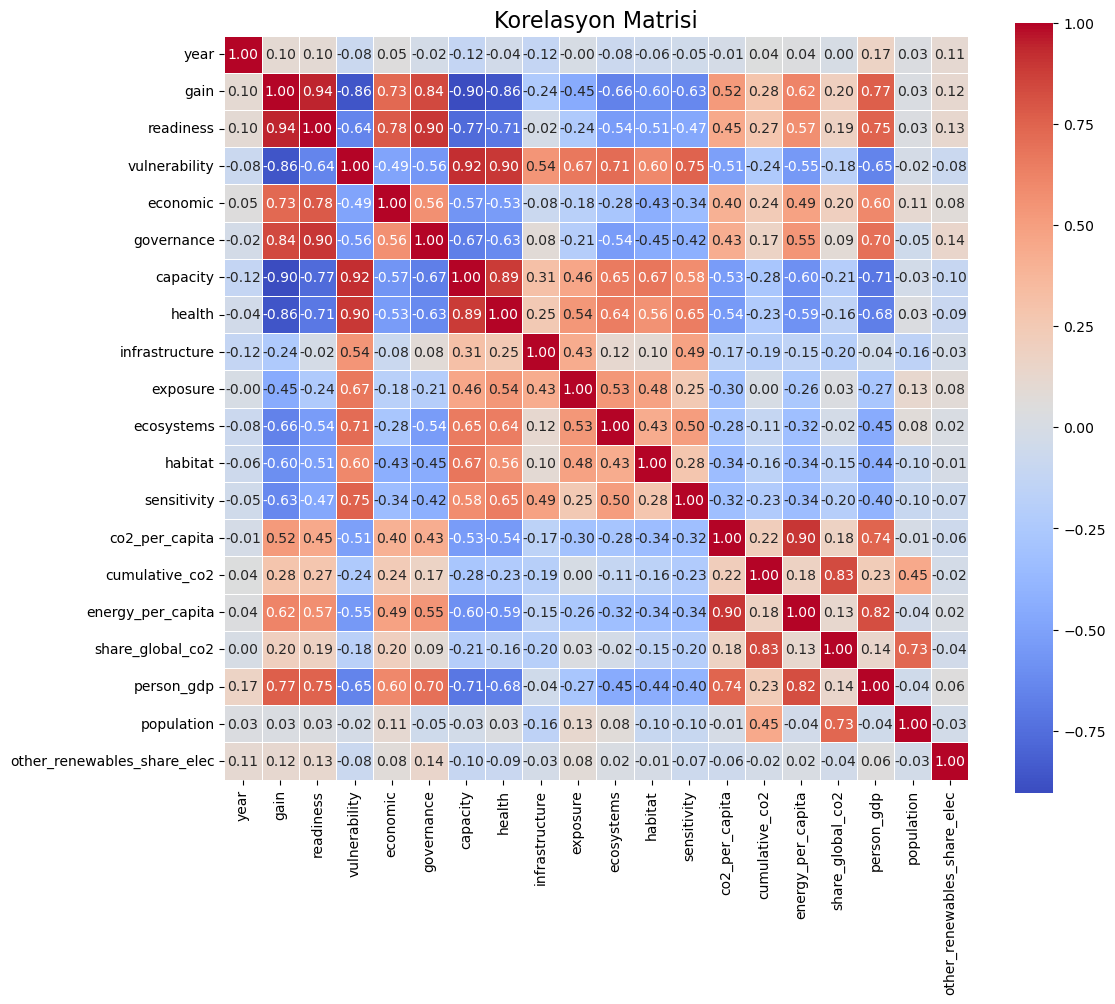

In [80]:
corr = df.corr(numeric_only=True)


plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=.5)
plt.title("Korelasyon Matrisi", fontsize=16)
plt.show()

In [81]:
# Korelasyonu zayıf, model için anlamlı katkı sunmayan kolonlar çıkarıldı
df.drop(["energy_per_capita", "other_renewables_share_elec", "infrastructure", "capacity"], axis=1, inplace=True),,,,

## Yıllara Göre Küresel Eğilimler: Hazırlık ve Emisyon Göstergeleri

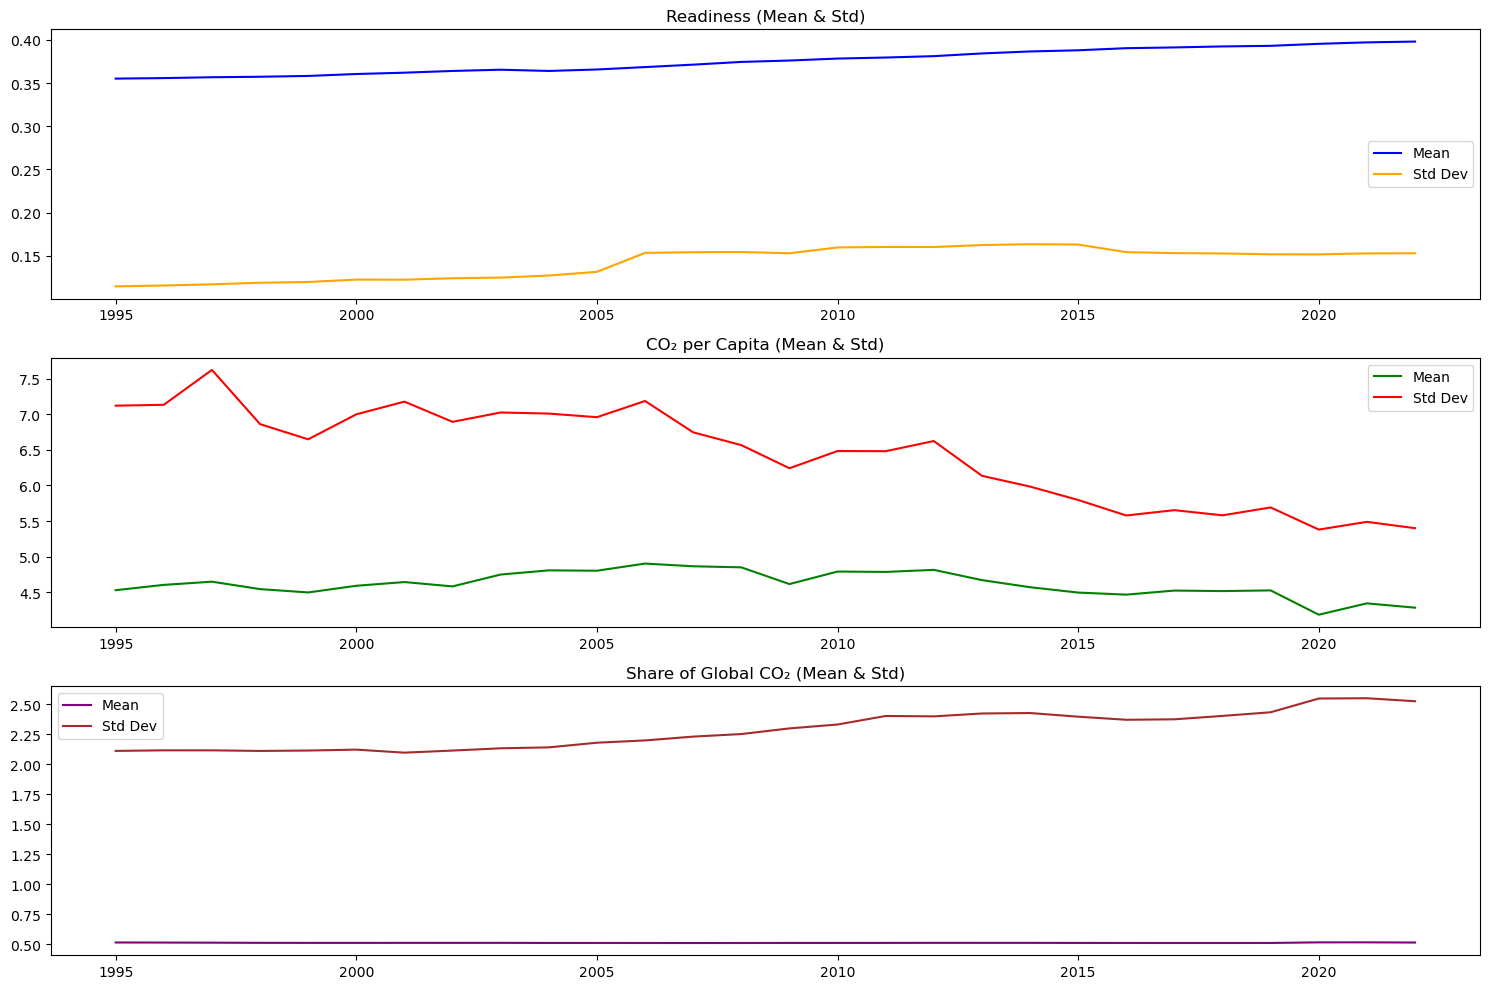

In [83]:
agg_df = df.groupby("year").agg({
    "readiness": ["mean", "std"],
    "co2_per_capita": ["mean", "std"],
    "share_global_co2": ["mean", "std"],
})

# Kolon adlarını sadeleştir
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df = agg_df.reset_index()

# Grafik çizimi
plt.figure(figsize=(15, 10))

# Readiness
plt.subplot(3, 1, 1)
plt.plot(agg_df["year"], agg_df["readiness_mean"], label="Mean", color="blue")
plt.plot(agg_df["year"], agg_df["readiness_std"], label="Std Dev", color="orange")
plt.title("Readiness (Mean & Std)")
plt.legend()

# CO2 per capita
plt.subplot(3, 1, 2)
plt.plot(agg_df["year"], agg_df["co2_per_capita_mean"], label="Mean", color="green")
plt.plot(agg_df["year"], agg_df["co2_per_capita_std"], label="Std Dev", color="red")
plt.title("CO₂ per Capita (Mean & Std)")
plt.legend()

# Share of global CO2
plt.subplot(3, 1, 3)
plt.plot(agg_df["year"], agg_df["share_global_co2_mean"], label="Mean", color="purple")
plt.plot(agg_df["year"], agg_df["share_global_co2_std"], label="Std Dev", color="brown")
plt.title("Share of Global CO₂ (Mean & Std)")
plt.legend()

plt.tight_layout()
plt.show()

### GRAFIK YORUM
Hazırlık yıldan yıla artıyor fakat standart sapma da 0.11 den 0.16 ya arttıgından ülkeler hızla iyileşirken diğerleri yerinde stabil kalıyor

Co2 emisyonunun sabit kalması ama hazırlığın artması, bazı ülkelerin gelişmişliği sayesinde sürdürülebilir çözümleri daha kolay uygulayabildiğini düşündüyor.

## Readiness Sınıflandırması & CO₂ Kişi Başı Dağılımı Haritası

In [86]:
# Bu adımda readiness skorları, her yılın ortalaması ve standart sapmasına göre sınıflandırılmıştır.
# Böylece yıllar arası mutlak farklardan ziyade hazırlık düzeyleri görünür hale gelmiştir.

### Eksik Ecosystem Verilerinin İncelenmesi
missing = df[df['ecosystems'].isnull()][['country', 'sensitivity', 'vulnerability', 'exposure']]
missing_flags = missing.isnull()
missing_flags['country'] = missing['country'].values
missing_summary = missing_flags.groupby('country').sum()

# Kritik girdileri eksik olan gözlemler için 'bayrak' oluşturuluyor
df['ecosystems_input_missing'] = df.apply(
    lambda row: int(pd.isnull(row['ecosystems']) and 
                    (pd.isnull(row['sensitivity']) or pd.isnull(row['exposure']) or pd.isnull(row['vulnerability']))),
    axis=1
)

### Yıl Bazında Readiness Ortalaması ve Standart Sapması Hesaplama
df_grouped = df.groupby("year")["readiness"].agg(readiness_mean="mean", readiness_std="std").reset_index()
df = df.merge(df_grouped, on="year", how="left")

### Readiness Segmentasyonu Fonksiyonu
def readiness_sinifi(row):
    if pd.isnull(row["readiness"]):
        return "Eksik Veri"
    elif row["readiness"] >= row["readiness_mean"] + row["readiness_std"]:
        return "Çok Yüksek"
    elif row["readiness"] >= row["readiness_mean"]:
        return "Yüksek"
    elif row["readiness"] >= row["readiness_mean"] - row["readiness_std"]:
        return "Düşük"
    else:
        return "Çok Düşük"

df["readiness_class"] = df.apply(readiness_sinifi, axis=1)

###  Hover Etiketi Hazırlama
df["hover_label"] = df.apply(
    lambda row: f"{row['country']}<br>CO₂ kişi başı: {row['co2_per_capita']:.2f} ton" 
    if pd.notnull(row["co2_per_capita"]) else f"{row['country']}<br>CO₂ verisi yok", 
    axis=1
)

###  Choropleth Haritası: Hazırlık Sınıfı ve CO₂ Kişi Başı
fig = px.choropleth(
    df,
    locations="iso_code",
    color="readiness_class",
    hover_name="hover_label",
    category_orders={
        "readiness_class": ["Çok Düşük", "Düşük", "Yüksek", "Çok Yüksek", "Eksik Veri"]
    },
    color_discrete_map={
        "Çok Düşük": "#c7e9c0",
        "Düşük": "#a1d99b",
        "Yüksek": "#238b45",
        "Çok Yüksek": "#00441b",
        "Eksik Veri": "lightgray"
    }
)

fig.update_layout(
    title_text="🌍 Readiness Sınıflandırması & CO₂ Kişi Başı Dağılımı",
    margin={"r":0, "t":50, "l":0, "b":0},
    coloraxis_sh-.-.owscale=False
)

fig.show()

### Yorum
Bu haritada, ülkeleri readiness skorlarına göre sınıflandırdım. Yeşil tonları hazırlık düzeyini, hover etiketleri ise kişi başı CO₂ emisyonunu gösteriyor. Bazı ülkeler çok düşük hazırlık seviyesinde ama neredeyse hiç emisyon üretmiyor.

## İklim Adaleti Üçgeni: Hazırlık ve Sorumluluk Karşılaştırması

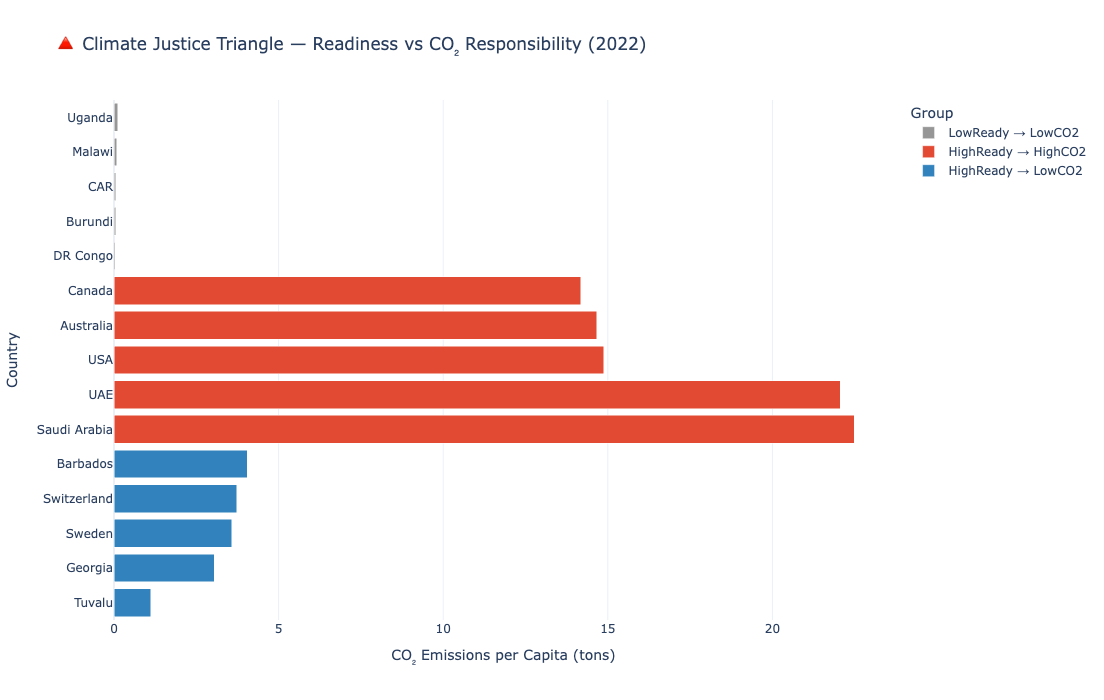

In [89]:
# Ülkeler ve kişi başı CO₂ değerleri
countries = [
    "Saudi Arabia", "UAE", "USA", "Australia", "Canada",
    "Tuvalu", "Georgia", "Sweden", "Switzerland", "Barbados",
    "DR Congo", "Burundi", "CAR", "Malawi", "Uganda"
]

co2 = [
    22.48, 22.06, 14.87, 14.67, 14.18,       # Very High Ready + High CO2
    1.12, 3.04, 3.57, 3.73, 4.05,            # Very High Ready + Low CO2
    0.04, 0.05, 0.05, 0.09, 0.12             # Very Low Ready + Low CO2
]

group = (
    ["HighReady_HighCO2"] * 5 +
    ["HighReady_LowCO2"] * 5 +
    ["LowReady_LowCO2"] * 5
)

color_map = {
    "HighReady_HighCO2": "#e34a33",  # Kırmızı
    "HighReady_LowCO2": "#3182bd",   # Mavi
    "LowReady_LowCO2": "#969696"     # Gri
}

colors = [color_map[g] for g in group]

# Grafik oluştur
fig = go.Figure()

for grp in set(group):
    indices = [i for i, g in enumerate(group) if g == grp]
    fig.add_trace(go.Bar(
        y=[countries[i] for i in indices],
        x=[co2[i] for i in indices],
        name=grp.replace("_", " → "),
        orientation='h',
        marker_color=color_map[grp]
    ))

# Düzenlemeler
fig.update_layout(
    title="🔺 Climate Justice Triangle — Readiness vs CO₂ Responsibility (2022)",
    barmode='stack',
    xaxis_title="CO₂ Emissions per Capita (tons)",
    yaxis_title="Country",
    height=700,
    legend_title_text="Group",
    template="plotly_white"
)

fig.show()

Bu grafik, üç farklı ülke grubunu readiness (hazırlık) düzeyi ve kişi başı CO₂ emisyonlarına göre sınıflandırıyor:

1️- HighReady → HighCO₂
Kanada, ABD, Suudi Arabistan Hazırlık düzeyleri yüksek ama kişi başı emisyonları da çok yüksek.  Bu ülkeler hem sorumlu hem de korunaklı.

2️- LowReady → LowCO₂
Malawi, Burundi  Ne iklim krizine hazırlar ne de bu krizi yaratmışlar. Krizi yaratmayanlar, etkilerine karşı en savunmasız olanlar.

3️- HighReady → LowCO₂
İsveç, Tuvalu, Barbados  Kişi başı emisyonları düşük ama hazırlık düzeyleri yüksek. Bu ülkeler, kaynaklarını verimli kullanarak dayanıklılık geliştirmişler. İlham verici örnekler.